# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import torch.optim as optim
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import operator
from datetime import datetime

from utilities import *
from model import *

# Define CUDA

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Dataset

In [3]:
#stocks dataset for Altaba Inc
stock_dataset = pd.read_csv('data/abaa.us.txt')
stock_dataset = stock_dataset.drop(columns=['OpenInt'])
display(stock_dataset)

,Date,Open,High,Low,Close,Volume
0,1996-04-12,1.05,1.790,1.02,1.38,408720000
1,1996-04-15,1.49,1.500,1.25,1.34,79231200
2,1996-04-16,1.34,1.340,1.17,1.20,48026400
3,1996-04-17,1.18,1.180,1.03,1.12,42871200
4,1996-04-18,1.25,1.250,1.17,1.22,27352800
...,...,...,...,...,...,...
5429,2017-11-06,70.27,71.960,70.27,71.71,7129828
5430,2017-11-07,72.20,72.470,71.62,72.22,9161521
5431,2017-11-08,72.00,72.200,71.09,71.16,7363365
5432,2017-11-09,70.46,70.680,68.77,70.19,10054663


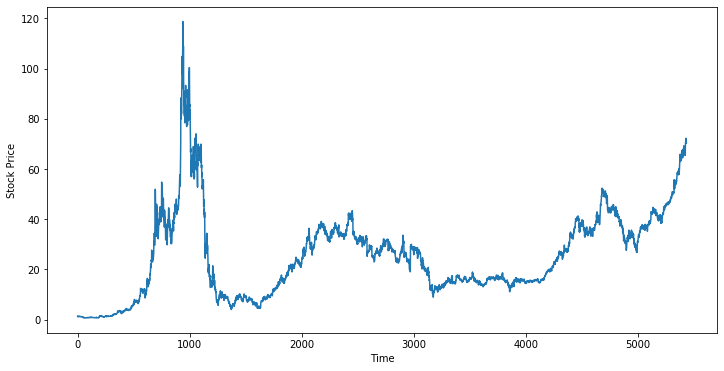

In [4]:
#close value is stock price at the end of that day
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(stock_dataset))), stock_dataset['Close'])
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Proprocess Dataset

In [5]:
#normalize dataset and keep track of close value
stock_dataset['Date'] = stock_dataset['Date'].apply(lambda x: string_to_time(x))
min_max_dictionary = min_max_dic(stock_dataset)
display(stock_dataset)

stock_value = stock_dataset[['Close']]

,Date,Open,High,Low,Close,Volume
0,0.000000,0.003378,0.008926,0.003368,0.006097,0.933697
1,0.000381,0.007189,0.006594,0.005462,0.005758,0.180999
2,0.000507,0.005889,0.005308,0.004734,0.004573,0.109714
3,0.000634,0.004504,0.004021,0.003459,0.003895,0.097937
4,0.000761,0.005110,0.004584,0.004734,0.004742,0.062486
...,...,...,...,...,...,...
5429,0.999493,0.602893,0.573221,0.633773,0.601660,0.016288
5430,0.999619,0.619609,0.577322,0.646063,0.605978,0.020929
5431,0.999746,0.617876,0.575151,0.641238,0.597002,0.016821
5432,0.999873,0.604538,0.562927,0.620118,0.588788,0.022969


In [6]:
#split data into training and testing components
x_train, y_train, x_test, y_test = split_data(stock_value, 20)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

# Initialize Hyperparameters

In [7]:
input_size = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
epochs = 400

# Define Model (GRU)

In [8]:
model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
loss_func = nn.MSELoss(reduction='mean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [9]:
train_loss = []
min_loss = np.Inf

for epoch in range(epochs):
    #zero out gradients
    optimizer.zero_grad()

    pred = model(x_train.to(device))
    loss = loss_func(pred, y_train.to(device))
    train_loss.append(loss.item())
    print('Epoch {},    Loss: {:.10f}\n'.format(epoch, loss.item()))
    
    #keep track of lowest loss and save as best model
    if loss.item() < min_loss:
        print('     New Minimum Loss: {:.10f} ----> {:.10f}\n'.format(min_loss, loss.item()))
        min_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pt')

    #back propogate
    loss.backward()
    optimizer.step()

----> 0.0001948439

Epoch 178,    Loss: 0.0001944475

     New Minimum Loss: 0.0001948439 ----> 0.0001944475

Epoch 179,    Loss: 0.0001940541

     New Minimum Loss: 0.0001944475 ----> 0.0001940541

Epoch 180,    Loss: 0.0001936639

     New Minimum Loss: 0.0001940541 ----> 0.0001936639

Epoch 181,    Loss: 0.0001932762

     New Minimum Loss: 0.0001936639 ----> 0.0001932762

Epoch 182,    Loss: 0.0001928918

     New Minimum Loss: 0.0001932762 ----> 0.0001928918

Epoch 183,    Loss: 0.0001925110

     New Minimum Loss: 0.0001928918 ----> 0.0001925110

Epoch 184,    Loss: 0.0001921332

     New Minimum Loss: 0.0001925110 ----> 0.0001921332

Epoch 185,    Loss: 0.0001917585

     New Minimum Loss: 0.0001921332 ----> 0.0001917585

Epoch 186,    Loss: 0.0001913870

     New Minimum Loss: 0.0001917585 ----> 0.0001913870

Epoch 187,    Loss: 0.0001910183

     New Minimum Loss: 0.0001913870 ----> 0.0001910183

Epoch 188,    Loss: 0.0001906520

     New Minimum Loss: 0.0001910183 ----> 0.00

# Evaluating Model

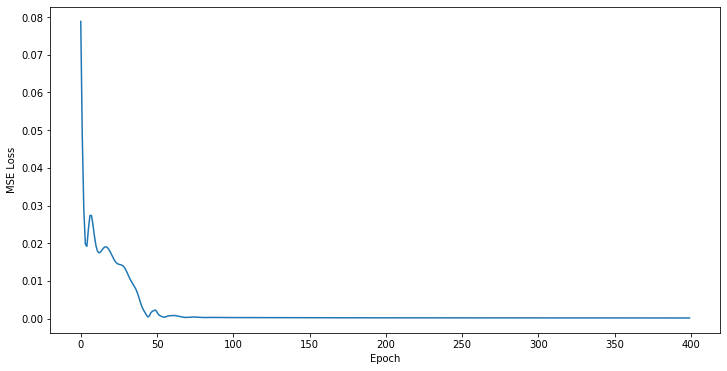

In [10]:
#visualize loss throughout training
plt.figure(figsize=(12, 6))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.plot(list(range(epochs)), train_loss)

# Load the Best Model

In [11]:
best_model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [12]:
#get predictions
lstm_predictions = model(x_test.to(device))
test_loss = loss_func(lstm_predictions, y_test.to(device))
lstm_predictions = lstm_predictions.squeeze().tolist()


# Reverse Normalize

In [13]:
min = min_max_dictionary['Close'][0]
max = min_max_dictionary['Close'][1]

#reverse normalize predictions and dataset values
lstm_predictions = [reverse_normalize(x, min, max) for x in np.array(lstm_predictions)]

stock_value = [reverse_normalize(x, min, max) for x in np.array(stock_value)]

# Visualizing and Testing Model

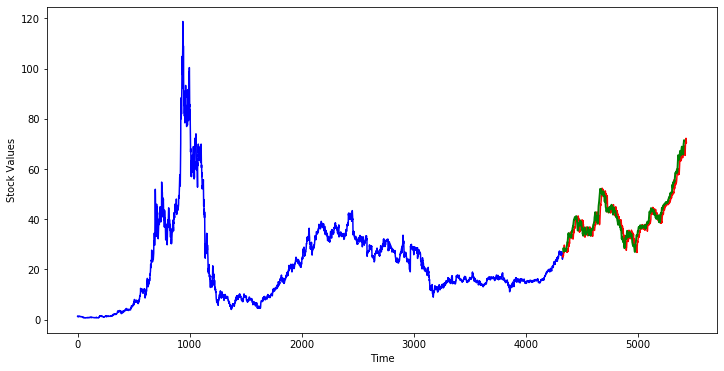

In [14]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(x_train.size(0))], stock_value[:x_train.size(0)], color='b', label='trained values')

#plot test range and predictions by the GRU
time_values_actual = list(range(x_train.size(0), len(stock_value)))
time_values_pred = list(range(x_train.size(0), x_train.size(0) + y_test.size(0)))
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.plot(time_values_actual, stock_value[-len(time_values_actual):], color='r', label='actual values')
plt.plot(time_values_pred[3:], lstm_predictions[3:], color='g', linewidth=2, label='predicted values')

plt.show()